<a href="https://colab.research.google.com/github/karri-ten/Plant-disease-detection/blob/main/Plant_Disease_Detection_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌿 Plant Disease Detection

In [ ]:
# ✅ Mount Google Drive (optional)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ✅ Enable GPU

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# ✅ Install Required Libraries

In [5]:
!pip install -q kaggle
!pip install -q gradio

In [ ]:
# ✅ Upload Kaggle API Token

In [6]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"teniolakareemat","key":"0a3af859538a3c98ede653ca6231f13a"}'}

In [ ]:
# ✅ Set up Kaggle credentials

In [7]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ✅ Download and unzip the dataset

In [8]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.02G/2.04G [00:14<00:00, 40.2MB/s]
100% 2.04G/2.04G [00:14<00:00, 154MB/s] 


In [ ]:
# ✅ Check folder structure

In [9]:
import os
print(os.listdir('./data/plantvillage dataset/'))
print(os.listdir('./data/plantvillage dataset/color/'))

['color', 'grayscale', 'segmented']
['Pepper,_bell___healthy', 'Potato___Early_blight', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Late_blight', 'Tomato___healthy', 'Cherry_(including_sour)___healthy', 'Grape___Black_rot', 'Peach___Bacterial_spot', 'Blueberry___healthy', 'Apple___Apple_scab', 'Tomato___Leaf_Mold', 'Apple___healthy', 'Apple___Cedar_apple_rust', 'Strawberry___Leaf_scorch', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Early_blight', 'Peach___healthy', 'Grape___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Potato___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Tomato___Bacterial_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Cherry_(including_sour)___Powdery_mildew', 'Strawberry___healthy', 'Pepper,_bell___Bacterial_spo

In [ ]:
# ✅ Prepare dataset, verify classes, and create loaders

In [11]:
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision.datasets.folder import default_loader
from collections import Counter
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_dir = './data/plantvillage dataset/color'
raw_dataset = datasets.ImageFolder(base_dir)
train_size = int(0.8 * len(raw_dataset))
val_size = len(raw_dataset) - train_size
train_data, val_data = random_split(raw_dataset, [train_size, val_size])

class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.loader = default_loader
        self.classes = subset.dataset.classes

    def __getitem__(self, index):
        path, target = self.subset.dataset.samples[self.subset.indices[index]]
        image = self.loader(path)
        return self.transform(image), target

    def __len__(self):
        return len(self.subset)

train_dataset = TransformedDataset(train_data, train_transforms)
val_dataset = TransformedDataset(val_data, val_transforms)
targets = [raw_dataset.samples[i][1] for i in train_data.indices]
class_counts = Counter(targets)
weights = [1.0 / class_counts[t] for t in targets]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = raw_dataset.classes
print("Total images in dataset:", len(raw_dataset))
print("Number of classes:", len(classes))
print("Sample classes:", classes[:10])

Total images in dataset: 54305
Number of classes: 38
Sample classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


In [ ]:
# ✅ Visualize class distribution

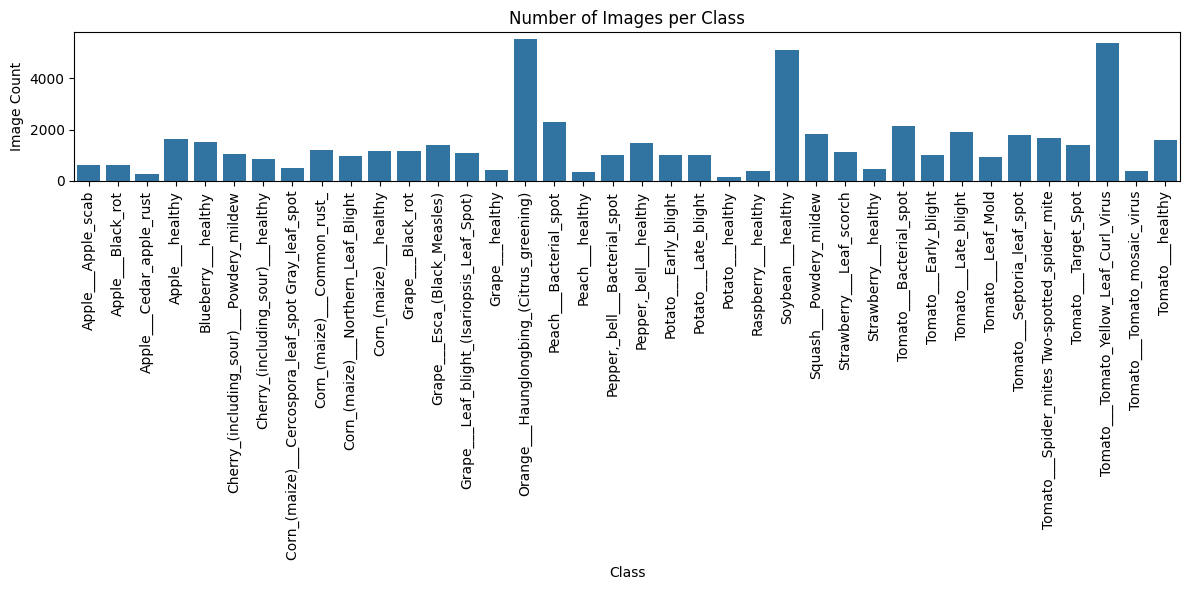

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
image_labels = [s[1] for s in raw_dataset.samples]
class_counts = Counter(image_labels)
labels = [classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=counts)
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

In [ ]:
# ✅ Load and customize EfficientNet

In [13]:
from torchvision import models
import torch.nn as nn
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 101MB/s]


In [ ]:
# ✅ Training config with scheduler

In [14]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# ✅ Training function with logging

In [15]:
def train_model(model, train_loader, val_loader, epochs=15):
    print("Training started...")
    for epoch in range(epochs):
        try:
            model.train()
            total_loss, correct = 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
            val_acc = evaluate(model, val_loader)
            scheduler.step()
            print(f"Epoch {epoch+1}: Loss={total_loss:.3f}, Train Acc={correct/len(train_loader.dataset):.3f}, Val Acc={val_acc:.3f}")
        except Exception as e:
            print(f"Error in epoch {epoch+1}: {e}")

In [ ]:
# ✅ Train the model

In [16]:
print("Starting model training...")
train_model(model, train_loader, val_loader, epochs=15)

Starting model training...
Training started...
Epoch 1: Loss=544.757, Train Acc=0.920, Val Acc=0.990
Epoch 2: Loss=53.937, Train Acc=0.988, Val Acc=0.995
Epoch 3: Loss=35.388, Train Acc=0.992, Val Acc=0.996
Epoch 4: Loss=27.305, Train Acc=0.994, Val Acc=0.994
Epoch 5: Loss=19.487, Train Acc=0.996, Val Acc=0.996
Epoch 6: Loss=11.988, Train Acc=0.997, Val Acc=0.997
Epoch 7: Loss=10.205, Train Acc=0.998, Val Acc=0.997
Epoch 8: Loss=7.798, Train Acc=0.998, Val Acc=0.998
Epoch 9: Loss=7.100, Train Acc=0.998, Val Acc=0.998
Epoch 10: Loss=6.819, Train Acc=0.998, Val Acc=0.998
Epoch 11: Loss=4.529, Train Acc=0.999, Val Acc=0.999
Epoch 12: Loss=2.645, Train Acc=1.000, Val Acc=0.999
Epoch 13: Loss=3.399, Train Acc=0.999, Val Acc=0.999
Epoch 14: Loss=3.290, Train Acc=0.999, Val Acc=0.998
Epoch 15: Loss=2.595, Train Acc=1.000, Val Acc=0.999


In [ ]:
#✅ Evaluate Accuracy on Validation Set

In [19]:
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"✅ Validation Accuracy: {accuracy:.4f}")
    return accuracy




In [20]:
# Run after training
evaluate_model(model, val_loader)

✅ Validation Accuracy: 0.9986


0.9986189117024216

In [ ]:
#✅  Classification Report (Precision, Recall, F1)

In [27]:
from sklearn.metrics import classification_report

def classification_report_val(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred, target_names=classes))

In [28]:
classification_report_val(model, val_loader)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       125
                                 Apple___Black_rot       1.00      1.00      1.00       131
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        53
                                   Apple___healthy       1.00      1.00      1.00       318
                               Blueberry___healthy       1.00      1.00      1.00       315
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       231
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       181
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.95      0.96       106
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       217
               Corn_(maize)___Northern_Leaf_Blight       0.98      0.99      0.

In [ ]:
# ✅ Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, val_loader):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, xticklabels=classes, yticklabels=classes, cmap='Blues', fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


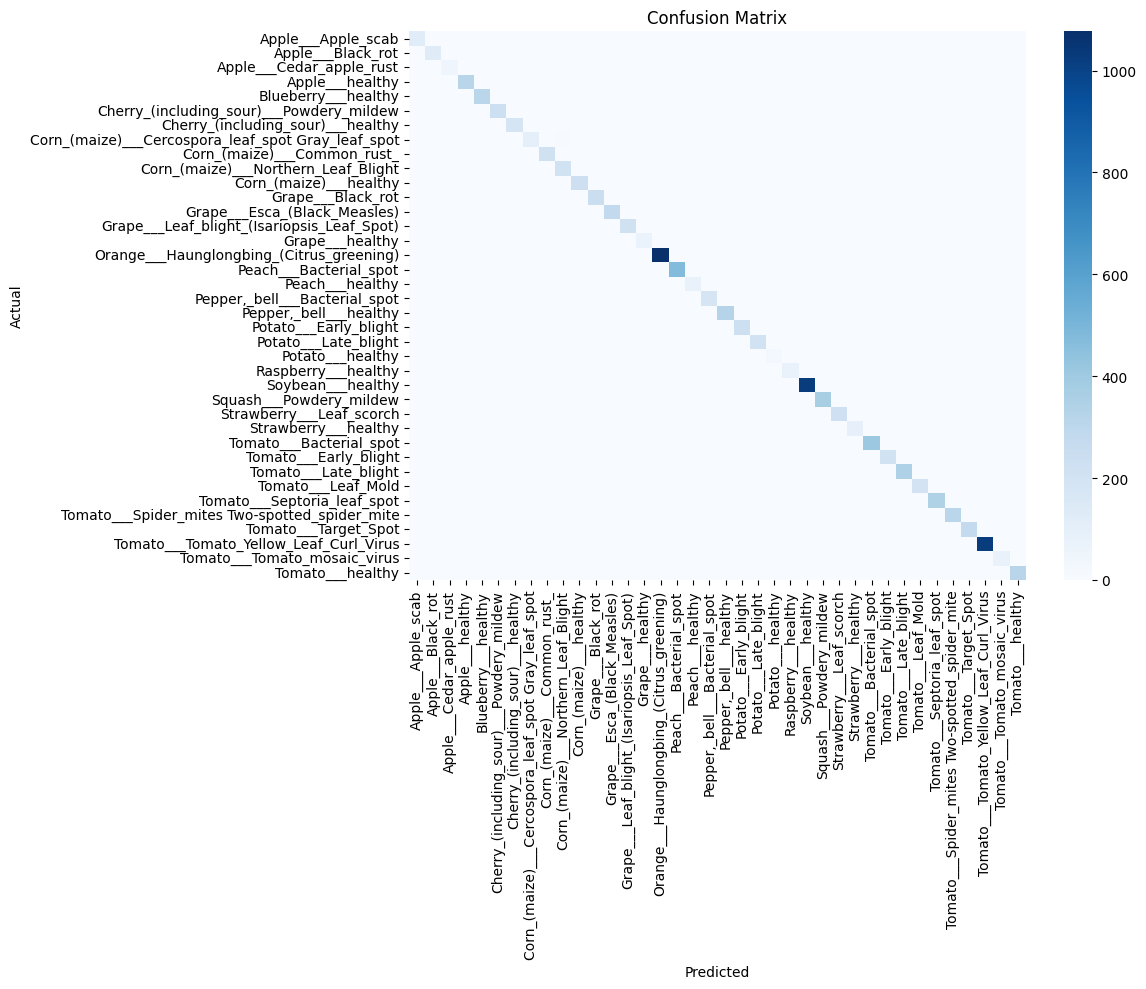

In [35]:
# Run after training
plot_confusion_matrix(model, val_loader)

In [ ]:
# ✅ Save and Reload Model

In [36]:
# Save model
torch.save(model.state_dict(), "plant_disease_model.pth")

# Load model
model.load_state_dict(torch.load("plant_disease_model.pth", map_location=device))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# ✅ Gradio Interface with confidence score

In [17]:
import gradio as gr
from PIL import Image
import torch.nn.functional as F

def gradio_predict(img):
    image_tensor = val_transforms(img.convert("RGB")).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
    label = classes[pred.item()]
    return {label: float(conf.item())}

with gr.Blocks(css='''
#component-0 {border: 4px solid #4CAF50; border-radius: 10px; padding: 20px; background-color: #f9fff9;}
h1, .output_class {color: #2E7D32; font-family: 'Segoe UI', sans-serif;}
button {background-color: #4CAF50; color: white; font-weight: bold; border-radius: 8px;}
''') as demo:
    gr.Markdown("# 🌿 Plant Disease Detector")
    gr.Markdown("Upload a leaf image to detect its disease.")
    with gr.Row():
        img_input = gr.Image(type="pil")
        output = gr.Label()
    btn = gr.Button("Predict")
    btn.click(gradio_predict, img_input, output)
demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d582c300a0edb1ddc1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d582c300a0edb1ddc1.gradio.live
